# Project 1: Linear Regression, Basis Expansion and Regularisation

## Statistical Machine Learning (COMP90051), Semester 2, 2017

*Copyright the University of Melbourne, 2017*

In this project, you will be required to write Python code, and also to answer a few theoretical questions. Your code will be assessed on the basis of (i) whether it works, e.g., does not result in an execution error, and (ii) whether it solves the specified task. It is not important whether your implementation is efficient, as long as it finishes execution within a reasonable amount of time. Note that the worksheet below is a combination of text, pre-implemented code and placeholders where we expect you to add your code and answers. Please follow the instructions carefully, **write your code and give answers only where specifically asked**.

** Marking:** You can get up to 22 marks for Project 1 (*this project*), and up to 33 marks for Project 2. The sum of marks for the two projects is then capped to 50 marks

**Due date:** 5 PM on Monday, the 4th of September 2017 (AEST)

**Late submissions** will incur a 10% penalty per calendar day

** Submission format:** You should use this IPython Notebook worksheet as a starting point, fill in your code and answers where required, and submit the completed worksheet (.ipynb file) via LMS.

**Academic Misconduct:** Your submission should contain only your own work and ideas. Where asked to write code, you cannot re-use someone else's code, and should write your own implementation. We will be checking submissions for originality and will invoke the University’s <a href="http://academichonesty.unimelb.edu.au/policy.html">Academic Misconduct policy</a> where inappropriate levels of collusion or plagiarism are deemed to have taken place.

**Table of Contents**

1. Linear Regression Model **(7 marks)**
  1. Analytic Solution
  2. Coordinate Descent Theory
  3. Coordinate Descent Implementation
  
2. Basis Expansion and Regularisation **(7 marks)**
  1. Polynomial Basis Functions
  2. Radial Basis Functions
  3. Ridge Regression

3. Regression on Real Data **(8 marks)**


## 1. Linear Regression Model

We start with setting up working environment.

In [124]:
%pylab
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


Now load some data. In the first two parts of this assignment we will be using a 1D dataset, because it is easy to visualise.

(30, 2)

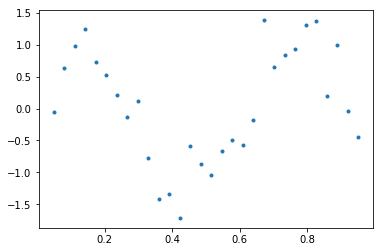

In [125]:
y_synth = np.array([
        -0.05167289, 0.63982603, 0.98123938, 1.24355676, 0.73023443, 0.53273977,
        0.20670524, -0.12854164, 0.12142414, -0.76777309, -1.4140911, -1.33854328,
        -1.71551542, -0.58528115, -0.87024253, -1.03868776, -0.67282369, -0.49697185,
        -0.56960248, -0.18382946, 1.386896, 0.65562566, 0.83638401, 0.94085044,
        1.3127219, 1.37959603, 0.20099471, 0.99189309, -0.04368285, -0.45082514])
y_synth = y_synth[:,np.newaxis]
n = y_synth.shape[0]
x_synth = np.linspace(0.05, 0.95, n)
x_synth = x_synth[:,np.newaxis]
plt.plot(x_synth, y_synth, '.')

# add a column of ones as a dummy feature
x_dummy = np.ones(x_synth.shape)
X_synth = np.column_stack((x_dummy, x_synth))
X_synth.shape

Here *x* is the input and *y* the output. Below you will learn models to predict *y* given *x*, using *X_synth* and *y_synth* for training.

**Note:** Do not overwrite global variables *X_synth*, *x_synth* and *y_synth*.

### 1.1 Analytic Solution
In this section, we apply linear regression directly. We will be using a regression with an intercept term. Therefore, despite the data being 1D, there are going to be two parameters.

Implement the analytic solution to linear regression in the following cell. This solution can be found in lecture slides. *Hint: use numpy.linalg.inv to compute matrix inverse.*

**Note:** For this task, you **cannot use** *numpy.linalg.solve*, *numpy.linalg.lstsq* or similar functions that provide an off-the-shelf implementation of the least-squares fit. Other libraries outside of *numpy* and *scipy* are also off limits, here and elsewhere in the project.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

In [126]:
# Input:
# X - is a matrix with N instances in rows and M features in columns
#     constant one column should already be included within X
# y - is an Nx1 column vector with response values
#
# Output:
# w_hat - is an Mx1 column vector with fitted weights
def least_squares_fit(X, y):
    w_hat_1 =  np.linalg.inv(np.dot(X.T, X))
    w_hat_2 =  np.dot(X.T, y)
    w_hat   =  np.dot(w_hat_1, w_hat_2)
    return w_hat

Now, use your *least_squares_fit* function to fit linear model to the synthetic dataset. Compute and print resulting weights and the corresponding sum of squared residuals (SSR). Plot the data overlaid by the linear fit.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

[[-0.13400438]
 [ 0.39018231]]
SSR :22.7253


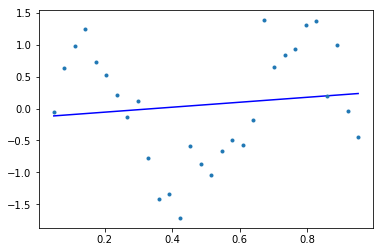

In [127]:
# use "least_squares_fit" function from above
# compute and print resulting weights and the corresponding SSR
# plot the data overlaid by the linear fit

w_hat = least_squares_fit(X_synth, y_synth)

#W_hat = np.linalg.solve(np.dot(X_synth.T, X_synth), np.dot(X_synth.T, y_synth))

f = np.dot(X_synth,w_hat)

plt.plot((x_synth), f,'b-')
plt.plot((x_synth), (y_synth),'.')

SSR  = ( (y_synth-f)**2).sum()
print(w_hat)
print('SSR :%0.4f'%SSR )

This is the best a straightforward linear model can do. You can verify that one cannot do better, by manually changing weights to different values (instead of fitting it automatically). You should not be able to achieve a smaller SSR. The non-linearity in the data can be addressed using basis expansion. But before moving on to this, we will try a different approach to solve linear regression.

### 1.2 Coordinate Descent Theory
In the next two sections, you will derive and implement coordinate descent algorithm for linear regression.

Suppose the training data contains $N$ instances and $M$ features so that $x_{ij}$ denotes the value of feature $j$ for instance $i$. Assume no bias term. Let $y_i$ denote the response value for training instance $i$. Recall that in linear regression, a model with weights $\textbf{w}$ is trained via minimisation of SSR, where the SSR is defined as

$$L( \textbf{w} ) = \sum_{i=1}^N  \left( y_i -  \sum_{j=1}^M w_j x_{ij} \right)^2$$

Let current weight estimates be $w_1,\ldots,w_M$. Consider weight $w_1$, and its coordinate descent update, i.e., the solution for the optimal $w_1$ value that minimises $L(\mathbf{w})$ while all other parameters are fixed. 

Prove that this update is

$$w_1^{new} = \frac{1}{\sum_{i=1}^N x_{i1}^2} \sum_{i=1}^N x_{i1}\left(y_i - \sum_{j=2}^M w_j x_{ij}  \right) $$

This involves partial differentiation of the SSR objective with respect to $w_1$, and equating this with 0. Show at least two intermediate steps. Clearly define any additional symbols that you introduce. Use LaTeX math typesetting.

*Hint: to learn about LaTeX typesetting, see how the above cell is formatted. You can copy and modify the equation above, i.e., ```$$w_1^{new} = \frac{1}{\sum_{i=1}^N x_{i1}^2} \sum_{i=1}^N x_{i1}\left(y_i - \sum_{j=2}^M w_j x_{ij}  \right) $$```.  There are also good tutorials online, e.g., from the [sharelatex](https://www.sharelatex.com/learn/Mathematical_expressions) webpage.*

In order to obtain estimate $w_1^{new}$ we need to minimize the SSR function $w$. A stepwise solution is described below

$$w_1^{new} = \min_{w_1} L(w)$$
Minimize this cost function over $w_1$ while all other variables are fixed, we can rewrite our cost function as 

$$L(w)=\sum_{i=1}^{N}\left(y_i - \sum_{j=2}^{M}w_jx_{ij} - w_1x_{i1}\right)^2$$
Expanding the above function resulted into following

$$\min_{w_1}\sum_{i=1}^{N}\left ( w_1^2x_{i1}^2 -2 w_1x_{i1}(y_i - \sum_{j=2}^{M} w_j x_{ij}) \right)$$

Applying the gradient and equating it to zero yeilds
$$\frac{\partial}{\partial w_1}\sum_{i=1}^{N}\left ( w_1^2x_{i1}^2 -2 w_1x_{i1}(y_i - \sum_{j=2}^{M} w_j x_{ij}) \right)  = 0$$


$$w_1 \sum_{i=1}^{N}x_{i1}^2  =\sum_{i=1}^{N} x_{i1}\left(y_i - \sum_{j=2}^{M}w_j x_{ij}\right)$$


Then updated  $ w_1$ is denoted by $w_1^{new}$, 

$$w_1^{new} = \frac{1}{\sum_{i=1}^{N} x_{i1}^2} \sum_{i=1}^{N} x_{i1} \left(y_i - \sum_{j=2}^{M}w_j x_{ij}\right)$$
Hence proved, where $w_1^{new}$ represents updated weight value by coordinate descent procedure.

### 1.3 Coordinate Descent Implementation

Now implement and run coordinate descent for linear regression.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

In [128]:
# Input:
# X - is a matrix with N instances in rows and 2 columns,
#     one of which is the constant one column
# y - is an Nx1 column vector with response values
# j - is the index of the weight to be updated, j=0,1
# w_curr - is an 2x1 column vector with the current estimate of weights
#
# Output:
# w_j_new - is a scalar containing the updated value of the j-th component
def coord_descent_iteration(X, y, j, w_curr):
    n,p = X.shape
    A = 0
    B = 0
    k= 1-j    
    for i in range(n):
        B+=np.dot(X[i,j],(y[i]- np.dot(w_curr[k],(X[i,k]))))
        A+=X[i,j]**2  
        w_j_new = B/A   
           
    return w_j_new    

Use the code below to test your coordinate descent method.

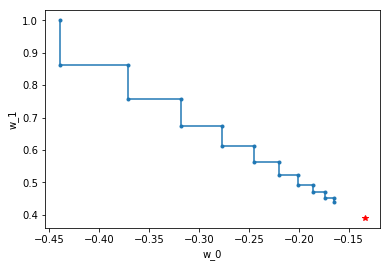

In [129]:
# coordinate descent
n_epochs = 10
n_features = X_synth.shape[1]

# starting guess
w_current = np.array([1, 1], dtype='float')
w_current.shape = (2,1)

# keep track of iterative improvement
w_trace = np.zeros((2, n_epochs*n_features))
trace_step = 0

for i in range(n_epochs):
    for j in range(n_features):
        w_j_new = coord_descent_iteration(X_synth, y_synth, j, w_current)
        w_current[j] = w_j_new;
        w_trace[:,trace_step] = w_current[:,0]
        trace_step += 1

# analytic solution
w_hat = least_squares_fit(X_synth, y_synth)

# plot results
plt.plot(w_trace[0,:], w_trace[1,:], '.-')
plt.plot(w_hat[0], w_hat[1], 'r*')
plt.xlabel('w_0')
plt.ylabel('w_1')


## 2. Basis Expansion and Regularisation

The dataset provided is not well modelled by a linear regression. We will now look at more advanced techniques for modelling the data using richer basis functions to represent the input, thus learning non-linear regression functions.

### 2.1 Polynomial Basis Functions

In this section, we explore polynomial basis functions. These basis functions are fairly straightforward for 1D data, as illustrated in the example snippet below.

original example point x = 0.5
transformed example point phi(x) = [[ 0.5      0.25     0.125    0.0625   0.03125]]


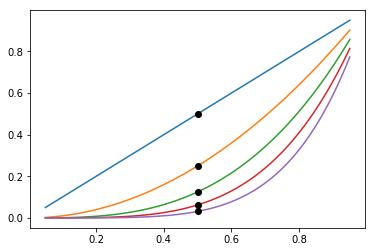

In [130]:
# plot polynomial functions, and a value of example input point
x_example = 0.5

n_poly = 5
x_poly = np.linspace(0.05, 0.95, 100)
x_phi = np.empty((n_poly, 1))

for i in range(n_poly):
    y_poly = x_poly ** (i + 1)
    v = x_example ** (i + 1)
    x_phi[i] = v
    plt.plot(x_poly, y_poly)
    plt.plot(x_example, v, 'ko')
    
print('original example point x =', x_example)
print('transformed example point phi(x) =', np.transpose(x_phi))
y = y_poly

Note that the example point is 1D in original feature space, and 5D in the new feature space.

Your task is to implement a method to apply a $M^{th}$ order polynomial expansion to a 1D input vector.

<br>
<font color='red'>**Write your code in the cell below ...**</font>

In [131]:
# Input:
# x - is an Nx1 column vector of features
# M - is the maximum polynomial degree, the new basis
#     should include M polynomials with degrees from 1 to M
#
# Output:
# Phi - is a NxM matrix of data in transformed feature space
#       dummy feature is not included
def expand_1d_to_poly(x, M):
    
    Phi = np.zeros((x.shape[0], M))
    for i in range(M):
        Phi[:,i] = x.T**(i+1)
        
        
    return Phi

Now, apply the transformation and use your *least_squares_fit* function to fit linear model in the transformed feature space. Do not forget to add the dummy variable. Compute and print resulting weights and the corresponding SSR. Plot original 1D data overlaid by the  fit.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

[[  -2.30242362]
 [  61.08670566]
 [-361.59408779]
 [ 784.47526064]
 [-699.33469842]
 [ 216.01839742]]
The error is: 3.3084


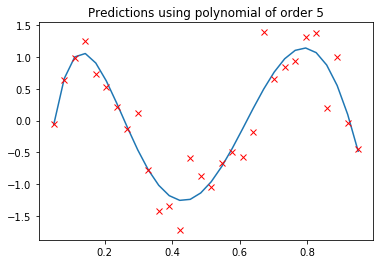

In [132]:
# use some maximum degree M > 2

# use "expand_1d_to_poly" function from above
# use "least_squares_fit" function from above

# compute and print resulting weights and the corresponding SSR
# plot the data overlaid by the fit
M = 5
Phi=expand_1d_to_poly(x_synth, M)
p_dummy = np.ones(Phi.shape[0])
Phi_d = np.column_stack((p_dummy, Phi))

w_hat = least_squares_fit (Phi_d, y_synth)

f = np.dot(Phi_d, w_hat)
SSR = sum((y_synth - f)**2)

print(w_hat)
print("The error is: %2.4f"%SSR)
plt.plot(x_synth, f)
plt.plot(x_synth, y_synth,'rx')
ax = plt.gca()
ax.set_title('Predictions using polynomial of order %d'%M)

Note that the fit is now non-linear in the original features space.

### 2.2 Radial Basis Functions

Another popular choice for basis expansion is radial basis functions (RBF). For our synthetic 1D data, we will use an RBF defined as $v(x)=\exp \left(-\frac{1}{\sigma}||x - z||^2\right)$. Parameter $z$ controls the location of the function, and $\sigma$ controls the spread. This function is implemented below.

In [133]:
# Input:
# x - is a column vector of input values
# z - is a scalar that controls location
# s - is a scalar that controls spread
#
# Output:
# v - contains the values of RBF evaluated for each element x
#     v has the same dimensionality as x
def radial_basis_function(x, z, s):
    # ensure that t is a column vector
    x = np.array(x)
    if x.size == 1:
        x.shape = (1,1)
    else:
        x_length = x.shape[0]
        x.shape = (x_length, 1)
    
    # compute RBF value
    r = np.linalg.norm(x - z, 2, 1)
    v = np.exp(-r**2/s)
    return v

Now use the code below to plot some RBF functions.

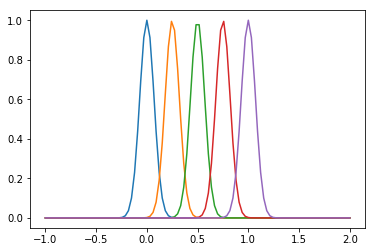

In [134]:
# number of RBF
n_rbf = 5

# locations and scale
z = np.linspace(0, 1, n_rbf)
sigma = 0.01 # same scale for each RBF

x_rbf = np.linspace(-1, 2, 100)
x_rbf = np.transpose(x_rbf)

for i in range(n_rbf):
    y_rbf = radial_basis_function(x_rbf, z[i], sigma)
    plt.plot(x_rbf, y_rbf)

Given an example point, visualise values of that point in the RBF space

original example point x = 0.5
transformed example point phi(x) = [[  1.38879439e-11   1.93045414e-03   1.00000000e+00   1.93045414e-03
    1.38879439e-11]]


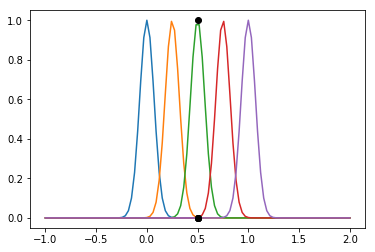

In [135]:
x_example = 0.5

# number of RBF
n_rbf = 5

# locations and scale
z = np.linspace(0, 1, n_rbf)
sigma = 0.01 # same scale for each RBF

x_rbf = np.linspace(-1, 2, 100)
x_rbf = np.transpose(x_rbf)

x_phi = np.zeros((n_rbf, 1))
for i in range(n_rbf):
    y_rbf = radial_basis_function(x_rbf, z[i], sigma)
    v = radial_basis_function(x_example, z[i], sigma)
    x_phi[i] = v
    plt.plot(x_rbf, y_rbf)
    plt.plot(x_example, v, 'ko')

print('original example point x =', x_example)
print('transformed example point phi(x) =', np.transpose(x_phi))

Note that the example point is 1D in original feature space, and 5D in the new feature space.

Now implement feature space transformation using RBFs.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

In [136]:
# Input:
# x - is an Nx1 column vector
# z - is an Mx1 column vector with locations for each of M RBFs
# s - is a scalar that controls spread, shared between all RBFs
#
# Output:
# Phi - is an NxM matrix, such that Phi(i,j) is the 
#       RBF transformation of x(i) using location z(j) and scale s
def expand_1d_to_RBF(x, z, s):
    Phi  = np.zeros((x.shape[0], z.shape[0]))
    for i in range(z.shape[0]):
        Phi[:,i] = radial_basis_function(x, z[i], s)
    return Phi

Now, apply the RBF transformation and use your *least_squares_fit* function to fit linear model in the transformed feature space. Do not forget to add the dummy variable. Compute and print resulting weights and the corresponding SSR. Plot original 1D data overlaid by the  fit.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

[[-24.21123399]
 [ 17.72837844]
 [  8.54666599]
 [  9.91252297]
 [ 11.18194474]
 [ 15.01055563]]
The error is: 3.5562


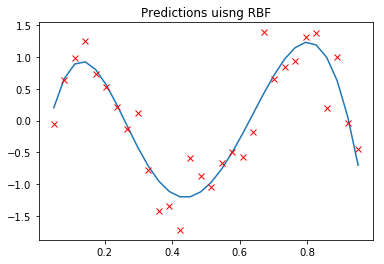

In [139]:
# you can use the same number of RBFs, their
# locations and scale as in the previous plot

# use "expand_1d_to_RBF" function from above
# use "least_squares_fit" function from above

# compute and print resulting weights and the corresponding SSR
# plot the data overlaid by the fit

# number of RBF
n_rbf = 5

# locations and scale
z = np.linspace(0, 1, n_rbf)
sigma = 0.1 # same scale for each RBF

Phi = expand_1d_to_RBF(x_synth, z, sigma) 
Phi = np.column_stack((x_dummy, Phi))

w_hat = least_squares_fit (Phi, y_synth)

f = np.dot(Phi, w_hat)
SSR = sum((y_synth - f)**2)

print(w_hat)
print("The error is: %2.4f"%SSR)
plt.plot(x_synth, f)
plt.plot(x_synth, y_synth,'rx')
ax = plt.gca()
ax.set_title('Predictions uisng RBF')

### Analysis

Compare the three methods of regression on this dataset: plain linear approach, polynomial basis expansion, and RBF basis expansion. For each method, name at least one aspect in which this method is advantageous compared to the other two methods. Justify your answer.

*Hint: think about making predictions outside the range of training data.*

<font color='red'>**Write your answer here (a short paragraph or two).**</font> (as a *markdown* cell)

### Comparison of regression methods 

One can model regression problem using different kinds of nonlinear basis functions. Linear regression can generalize estimate of the data points better if the dataset is linear, however, if data is nonlinear or curvilinear simple linear regression will fit a line producing higher bias and low variance therefore data fitting using nonlinear basis function (polynomial, radial etc) can help us to predict response data better.

In polynomial regression (parametric model) number of polynomials increases exponentially and globally effect each regions of input space, overfitting arises because of excessive training of the data and rigidity in smootheness, therefore, model generalization suffers. Because of poor extrapolation properties, these basis functions provide a estimate of response data within its range, however, data fitting performance suffers outside the range of data. Asymptotic performance of polynomials also suffers if the number parameters grows which in turn require higher degree polynomial functions, therefore, resultant models could be unstable.    

In case of RBF (nonparametric model) complexity of model grows with input data, however, it provides functions that are differentiable at each point, therefore it can represent complex relationships with increasing amount of data as a result of which number of computations grows and bias gets higher. Furthermore, in RBF it is required to choose parameter $\boldsymbol{z}_i$ and new features size beforehand. 

At lower number of basis vectors, polynomial basis out perform  as compared with RBF in prediction error and data fitting, however when we increased number of basis vectors e.g 10, RBF exhibit slighly lower prediction error of 3.1 and better fitting compared to polynomial basis for which prediction error is 3.2. So if the assumptions are clearly defined that the ground truth function can be approximated by linear or polynomial function, then polynomial functions should be preffered over RBF as they can fit polynomial using lesser data than RBF. In fact, there is no ground breaking technique of choosing what basis functions to use to model data using regression, as the data size grows both functions results in slow learning and degradation in prediction performance.   

### 2.3 Ridge Regression

In this section, we are going to use ridge regression to achieve two goals: (i) resistance to irrelevant features and (ii) control over the model complexity.

Our current solution cannot handle irrelevant features. For example, if matrix with data contains duplicate columns (features), the operation of taking the inverse will result in an execution error. Note that computing matrix inverse with nearly collinear (irrelevant) features will not result in an execution error, but might produce a nonsense result. Methods for detecting near collinearity are outside the scope of this project. Therefore, if you suspect (near) collinearity, use one of regularisation methods, e.g., ridge regression.

Implement ridge regression. *Hint: use np.linalg.inv*

**Note:** For this task, you **cannot use** *sklearn.linear_model.Ridge*, *numpy.linalg.lstsq* or similar functions that provide an off-the-shelf implementation of ridge regression.

<br>

<font color='red'>**Write your code in the cell below ...**</font>

In [140]:
# Input:
# X - is a matrix with N instances in rows and M features in columns
#     constant one column should already be included within X
# y - is an Nx1 column vector with response values
# l - is a scalar, regularisation parameter
#
# Output:
# w_hat - is an Mx1 column vector with fitted weights
def reg_least_squares_fit(X, y, l):
    w_hat_1 = np.linalg.inv( np.dot(X.T, X) + l*np.eye (X.shape[1]))
    w_hat_2 = np.dot(X.T, y)
    w_hat   = np.dot(w_hat_1, w_hat_2)
    return w_hat

Next, we are going to use held-out validation in order to assess the ability of our model to *extrapolate*. We will control model complexity using your implementation of ridge regression implemented.

Plot train and test error as a function of the regularisation parameter.

<br>

<font color='red'>**Complete the code below ...**</font>

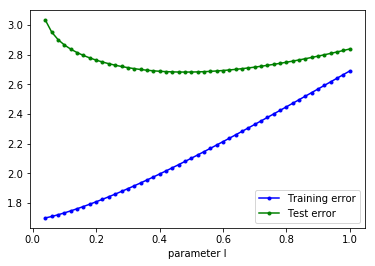

In [141]:
# students to write this code

# fill in the gaps
# use "expand_1d_to_RBF" and "reg_least_squares_fit" functions from above
# do not forget to add a dummy variable

# number of RBF
n_rbf = 10

# locations and scale
z = np.linspace(0, 1, n_rbf)
sigma = 0.01 # same scale for each RBF

# train and test split for the purpose of extrapolation
np.random.seed(2017) # for reproducibility
n_instances = x_synth.shape[0]
idx_train = range(0, n_instances, 2)
idx_test = range(1, n_instances, 2)

x_synth_train = x_synth[idx_train,:]
y_synth_train = y_synth[idx_train,:]
x_synth_test = x_synth[idx_test,:]
y_synth_test = y_synth[idx_test,:]

x_dummy_1 = np.ones(x_synth_train.shape[0])

Phi_train = expand_1d_to_RBF(x_synth_train, z, sigma)
Phi_train = np.column_stack((x_dummy_1, Phi_train))

Phi_test = expand_1d_to_RBF(x_synth_test, z, sigma)
Phi_test = np.column_stack((x_dummy_1, Phi_test))
# vary the regularisation parameter
l_start = 0.02
l_stop = 1
l_step = 0.02

l_values = []
ssr_trend_train = []
ssr_trend_test = []

l = l_start
while l <= l_stop:
    # Solve the linear system using Ridge regression
    w_hat = reg_least_squares_fit (Phi_train, y_synth_train, l)
    
    # Make predictions at training and test points
    f_train = np.dot(Phi_train, w_hat)
    f_test = np.dot(Phi_test, w_hat)
    
    #Compute errors and append it to a list
    error = ((y_synth_test - f_test)**2).sum()
    ssr_trend_test.append(error)
    train_error = ((y_synth_train - f_train)**2).sum()
    ssr_trend_train.append(train_error)
    l += l_step
    l_values.append(l)

plt.plot(l_values, ssr_trend_train, '.-b', label = 'Training error')
plt.plot(l_values, ssr_trend_test, '.-g',label='Test error')
plt.xlabel('parameter l')
plt.legend(loc=4)


## 3. Regression on Real Data

In the final part of this project, we will work with a real-world dataset. Here, we will use linear regression to predict petrol consumption in liters per 10 km from the following features: number of cylinders, displacement, horsepower, weight, acceleration, model year. All of these features are different characteristics of cars. The exact meaning of each quantity is not important for the task. Run the following cell to load the data into variables *X_real* (cars in rows and features in columns) and *y_real* (response values).

In [142]:
X_real = np.array([
[6.0, 250.0, 72.0, 3432.0, 21.0, 75.0],
[6.0, 250.0, 100.0, 3282.0, 15.0, 71.0],
[6.0, 231.0, 110.0, 3415.0, 15.8, 81.0],
[4.0, 140.0, 75.0, 2542.0, 17.0, 74.0],
[8.0, 351.0, 158.0, 4363.0, 13.0, 73.0],
[4.0, 68.0, 49.0, 1867.0, 19.5, 73.0],
[8.0, 318.0, 150.0, 4190.0, 13.0, 76.0],
[8.0, 318.0, 140.0, 3735.0, 13.2, 78.0],
[6.0, 156.0, 122.0, 2807.0, 13.5, 73.0],
[4.0, 97.0, 60.0, 1834.0, 19.0, 71.0],
[8.0, 302.0, 139.0, 3570.0, 12.8, 78.0],
[6.0, 232.0, 100.0, 2789.0, 15.0, 73.0],
[4.0, 91.0, 53.0, 1795.0, 17.5, 75.0],
[6.0, 198.0, 95.0, 2833.0, 15.5, 70.0],
[4.0, 97.0, 78.0, 2300.0, 14.5, 74.0],
[8.0, 318.0, 210.0, 4382.0, 13.5, 70.0],
[6.0, 198.0, 95.0, 3102.0, 16.5, 74.0],
[8.0, 454.0, 220.0, 4354.0, 9.0, 70.0],
[6.0, 232.0, 100.0, 2634.0, 13.0, 71.0],
[4.0, 85.0, 70.0, 2070.0, 18.6, 78.0],
[8.0, 318.0, 150.0, 3436.0, 11.0, 70.0],
[4.0, 97.0, 88.0, 2279.0, 19.0, 73.0],
[4.0, 121.0, 110.0, 2660.0, 14.0, 73.0],
[6.0, 225.0, 85.0, 3465.0, 16.6, 81.0],
[4.0, 105.0, 63.0, 2125.0, 14.7, 82.0],
[8.0, 400.0, 150.0, 4997.0, 14.0, 73.0],
[8.0, 318.0, 140.0, 4080.0, 13.7, 78.0],
[4.0, 112.0, 85.0, 2575.0, 16.2, 82.0],
[4.0, 98.0, 68.0, 2135.0, 16.6, 78.0],
[6.0, 225.0, 100.0, 3651.0, 17.7, 76.0],
[8.0, 340.0, 160.0, 3609.0, 8.0, 70.0],
[8.0, 400.0, 167.0, 4906.0, 12.5, 73.0],
[6.0, 200.0, 85.0, 2990.0, 18.2, 79.0],
[4.0, 140.0, 90.0, 2264.0, 15.5, 71.0],
[4.0, 151.0, 90.0, 2670.0, 16.0, 79.0],
[8.0, 350.0, 145.0, 4055.0, 12.0, 76.0],
[6.0, 258.0, 110.0, 3730.0, 19.0, 75.0],
[6.0, 231.0, 115.0, 3245.0, 15.4, 79.0],
[4.0, 91.0, 68.0, 2025.0, 18.2, 82.0],
[6.0, 231.0, 105.0, 3380.0, 15.8, 78.0],
[6.0, 168.0, 116.0, 2900.0, 12.6, 81.0],
[8.0, 318.0, 150.0, 3399.0, 11.0, 73.0],
[8.0, 400.0, 175.0, 5140.0, 12.0, 71.0],
[8.0, 429.0, 198.0, 4952.0, 11.5, 73.0],
[8.0, 302.0, 140.0, 4294.0, 16.0, 72.0],
[8.0, 302.0, 140.0, 4638.0, 16.0, 74.0],
[8.0, 455.0, 225.0, 4425.0, 10.0, 70.0],
[4.0, 140.0, 90.0, 2408.0, 19.5, 72.0],
[4.0, 120.0, 88.0, 2957.0, 17.0, 75.0],
[6.0, 171.0, 97.0, 2984.0, 14.5, 75.0],
])

y_real = np.array([63.8, 80.8, 95.2, 106.3, 55.3, 123.3, 68.0, 82.5, 85.0, 114.8, 85.9, 76.5, 140.3, 93.5, 110.5, 46.8, 85.0, 59.5, 80.8, 167.5, 76.5, 85.0, 102.0, 74.8, 161.6, 46.8, 74.4, 131.8, 125.4, 85.0, 59.5, 51.0, 84.2, 119.0, 120.7, 55.3, 63.8, 91.4, 157.3, 87.6, 108.0, 63.8, 55.3, 51.0, 55.3, 59.5, 59.5, 85.0, 97.8, 76.5, ])
y_real.shape = (X_real.shape[0], 1)

For each step below, where answer is required, write no more than a few sentences. You can interleave code cells with markdown cells containing your answers. *Make it clear which of the questions 3.1 ... 3.3 each of your cell answers.*

**3.1** Do you think that any preprocessing is required for this dataset? Explain your answer.

**3.2** Fit ridge regression without any basis expansion. Set regularisation parameter to 0.01. Do you think a plain linear model is adequate for this dataset? Justify your answer, e.g., using a plot that characterises resulting fit.

**3.3** Fit ridge regression in transformed feature space. You can use any feature transformation (polynomial, RBF or anything else). Justify your choice of the regularisation parameter. Compare results from steps 3.2 and 3.3. Do you think your results are reasonably good? Justify your answer. *Hint: think about prediction error per 10 liters*


<br>

<font color='red'>**Write your code and answers below ...**</font> (use both code cells and markdown cells)

#### 3.1  Why preprocessing?

This data requires preprocessing in order to perform regression. Because if we plot the design matrix $X_{real}$ we can see that each explanatory variables are different in scale, that means their mean and standard deviation values are not the same. In order to correct this differences in scales, we can use zscore to set the zero mean and unit standard deviation. Standardization is crucial in this case as the feature variables corresponds to different quantities and numeric values are on different scales of magnitude. Also as there is no prior specification to priortize a particular feature variable.
We can use function 'standardize' defined in the next cell to obtain standardized $X_{real}$ and centered variable $y_{real}$ 

(<matplotlib.axes._subplots.AxesSubplot at 0x14c49f28>,
 <matplotlib.text.Text at 0x14d01828>)

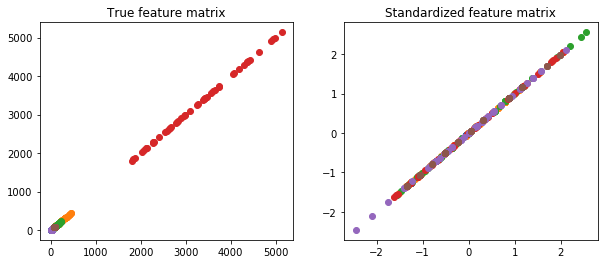

In [143]:
#%% Section 3.1

def standardize(X, y):
    Xmu = X.mean(axis=0)
    Xstd = X.std(axis=0)
    ymu = y.mean(axis=0)
    ystd = y.std()
    X_sd = (X - Xmu) / Xstd
    y_cent = y - ymu

    return X_sd, y_cent, Xstd, Xmu, ymu, ystd

X_sd, y_cent, Xstd, Xmu, ymu, ystd=standardize(X_real, y_real)

def normalize (X):
    Xmin = X.min()
    Xmax = X.max()
    X_norm = (X - Xmin )/ (Xmax - Xmin)
    return X_norm

X_norm = normalize (X_sd)



plt.figure(figsize=(10, 4))
plt.subplot(121),plt.plot(X_real, X_real,'o'),plt.title('True feature matrix')
plt.subplot(122),plt.plot(X_sd, X_sd,'o'), plt.title('Standardized feature matrix')

Weights:[[ -2.49083989e-15]
 [ -1.30372475e+01]
 [  1.08943509e-01]
 [  3.06361666e+00]
 [ -1.62875179e+01]
 [ -4.42918540e+00]
 [  9.89115300e+00]]
SSR :7410.8331
R-Squared :0.8350 


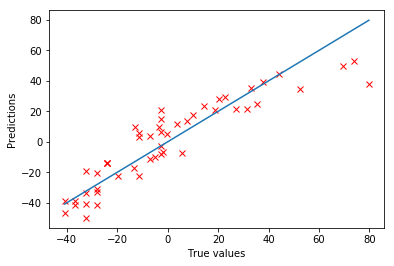

In [144]:
#%% Section 3.2


# fitting of ridge regression

n = X_sd.shape[0]
l = 0.01
Phi_real = np.column_stack((np.ones(X_sd.shape[0]), X_sd))
# Solve the linear system using Ridge regression
w_hat_real = reg_least_squares_fit (Phi_real, y_cent, l)    
# Make predictions 
f_hat_real = np.dot(Phi_real, w_hat_real)
#Compute errors and append it to a list
error = ((y_cent - f_hat_real)**2).sum()
y_temp = np.linspace(np.min(y_cent), np.max(y_cent), n)  

# plot of response variables
plt.figure(0)
plt.plot(y_cent, f_hat_real, 'rx')
plt.plot(y_temp,y_temp)
plt.xlabel('True values')
plt.ylabel('Predictions')
    
print('Weights:' +str(w_hat_real))

print ('SSR :%0.4f' %(error))
#function for computing R squared measure
def coeff_det (y, y_hat):
    y_res = sum((y_hat- np.mean(y))**2)
    y_tot = sum((y- np.mean(y))**2)
    rSquared = y_res/y_tot
    return rSquared


R = coeff_det(y_cent, f_hat_real)
print ('R-Squared :%0.4f '%(R))


#### 3.2 Model Appropriateness
Scatter plots shown above exhibit the two response datum predicted and orignal where straight line (blue) is arbitrary. Bias in this case is high as the ground truth is a noisy variable and there is some degree of linear trend. According to Bishop (1995) ridge regression performs better on noisy observations and provide improved prediction error. In general ,these observations could contain redundant information and prediction peformance can be improved by choosing an optimal value of regularization parameter $\lambda$. To demonstrate appropriateness of the model, we calculated sum of squared (SSR) and $R^2$ measures for ridge regression model which tells us about approximation accuracy represented by a value from $0-1$. An $R^2$ value of 0.8350 at $\lambda = 0.01$ suggest that model is appropriate, we can interpret it this way, that 83.50% of the variance is being explained by feature variables.  However we can improve upon $R^2$ and SSR value using slowly varying nonlinear basis functions described earlier and performing held out validation. 

We can try to learn a model which can fit not only the
training data, but is also able to explain the data which it has not used
during training stage. If the learned model is complex, it might overfit
the data, leading to high variance, and if the model is simple enough, it
might not be able to fit the data, leading to high bias. We have to be the
mediators between two problems. Another way to say this is just having a
model which fits the training data well doesn't mean that it is a good model
as the prediction error of model will always be lower on the training set than
any other dataset. In order to learn a model that fits the training data well
and is also able to explain the unseen data, we can use the technique of **held out validation**.

In [145]:
#%% Section 3.3
#Split the data into test and train
from sklearn.model_selection import train_test_split
  
X_train, X_test, y_train, y_test = train_test_split(X_sd, y_cent, test_size=0.4, random_state=0)
X_train.shape,X_test.shape, y_train.shape

((30, 6), (20, 6), (30, 1))

In [146]:

x_dummy_train = np.ones(X_train.shape[0])
x_dummy_test = np.ones(X_test.shape[0])

Phi_train  = np.zeros(X_train.shape)
Phi_test   = np.zeros(X_test.shape)

Phi_train = np.column_stack((x_dummy_train,X_train, X_train**2 ))
Phi_test  = np.column_stack((x_dummy_test,X_test, X_test**2 ))

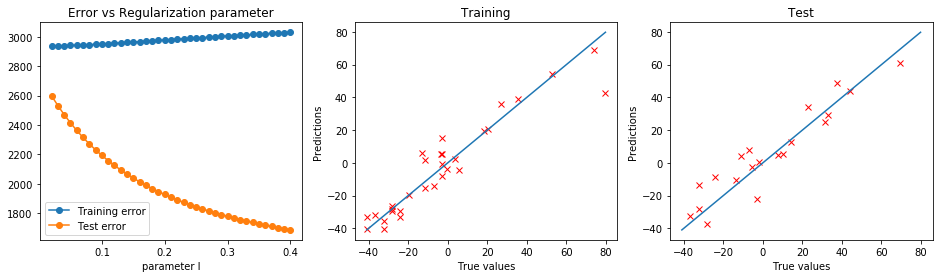

In [147]:
# vary the regularisation parameter
l_start = 0.01
l_stop =.4
l_step = 0.01

l_values = []
ssr_list_train = []
ssr_list_test  = []
l = l_start
temp_train = []
temp_test = []
while l <= l_stop:
    # Solve the linear system using Ridge regression
      w_hat = reg_least_squares_fit (Phi_train, y_train, l)
     # Make predictions 
      y_hat_train = np.dot(Phi_train, w_hat)
      y_hat_test = np.dot(Phi_test, w_hat)
       
      temp_train.append(y_hat_train)
      temp_test.append(y_hat_test)
     
    #Compute errors and append it to a list
      error_train =((y_train - y_hat_train)**2).sum()
      ssr_list_train.append(error_train)
      error_test  =((y_test - y_hat_test)**2).sum()
      ssr_list_test.append((error_test))
      l += l_step
      l_values.append(l)
temp_train=np.hstack(temp_train)
temp_train=np.mean(temp_train,1)
temp_test=np.hstack(temp_test)
temp_test=np.mean(temp_test,1)

plt.figure(figsize=(16, 4)) 
plt.subplot(131),plt.plot(l_values, ssr_list_train, '-o', label = 'Training error')
plt.plot(l_values, ssr_list_test,'-o',label='Test error')
plt.xlabel('parameter l')
plt.legend(loc=3)
plt.title('Error vs Regularization parameter' )
plt.subplot(132)
plt.plot(y_train, temp_train,'rx')
plt.plot(y_temp, y_temp)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('Training')
plt.subplot(133)
plt.plot(y_test, temp_test,'rx')
plt.plot(y_temp, y_temp)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('Test')

### 3.3 Discussion on results and choice of regularization parameter 
As there is less amount of data available therefore held out validation can be useful to generalize unseen data. 
#### Using polynomial basis function for ridge regression
To compare both results from simple linear ridge regression and ridge regression using polynomial basis we have shown plots of data fitting and sum of squared errors. We have used polynomial basis of order 2. Benefit of using polynomial basis is that these functions can be computed easily and fit the data well. However, if we increase the order of polynomial it tends to decrease prediction error (test error) and it exactly fits the data however, this setting leads to overfitting. By using less number of basis functions we can see that prediction error is higher. This also reflects that model is sensetive to degree of polynomial therefore, we decreased order of model and learned a model of degree 2. Prediction error is almost twice lower than performing ridge regression without basis functions.  Matrix of second order polynomials can be expressed as 
$$\Phi = \left[1, X_{real}, X^2_{real}\right] $$
#### Choice of $\lambda$
Due to lower complexity of the model, it can be seen that training error is high and test error is decreasing after a specific range of values of regularization parameter $\lambda$, prediction performance drastically degrades if we increase the value of $\lambda$ as a result of which data fitting also deteriorate.  The optimum range of values lies in vicinity of $\lambda \in(0.1\; \text{to} \;0.3)$ where prediction error is decreasing and training error is also low and predicted observed data follow the pattern of originally observed data resulting in better fitting as compared to simple linear ridge regression. If we increase value of $\lambda$ estimated weights shrink towards zero (not exactly zero) which leads to higher bias and lower variance. Coversely, lower value of regularization parameter results in higher variance and lower bias (which shows good fit between original and averaged predicted data). However, lower value of lambda could lead to overfitting therefore choice of $\lambda$ solely depends upon the given data. In order to further understand the choice of lambda we should revisit the ridge optimization problem i.e
$$\min_{\boldsymbol{w}} ||\boldsymbol{y} - \boldsymbol{Xw}||_2^2 + \lambda ||\boldsymbol{w}||_2^2$$
Here $\lambda$ is positive parameter that provides balance between both terms. First term $||\boldsymbol{y} - \boldsymbol{Xw}||_2^2 $ describes how well $\boldsymbol{w}$ approximate response variable $\boldsymbol{y}$, if this term gets too large then approximated solution $\boldsymbol{w}$ will lead to poor performance  measured by goodness of fit. In addition, if average size of errors in $\boldsymbol{y}$ is less than residual then this could result into fitting noise in the data.  Whereas the term $||\boldsymbol{w}||_2^2$ controls high frequency components that in result suppresses the noise in the data. 

These two terms are controlled by $\lambda$ which shrink weights to zero as the $\lambda$ tends to infinity. Similarly, if $\lambda$ tends towards zero resultant weights fit the noisy data and solution is unstable. Therefore, it is crucial to find a range of values for lambda where it provides stability in the solution and at the same time exhibit good data fitting.

Weights:[[-13.03435204]
 [ -1.43537239]
 [ -2.28287856]
 [ -5.499572  ]
 [-17.90876544]
 [ -3.07836215]
 [  8.13497585]
 [  4.61267833]
 [  2.57911226]
 [  1.50472667]
 [  3.24446199]
 [ -2.23033075]
 [  3.33152415]]
SSR :4220.1930 
R-Squared :0.9053 


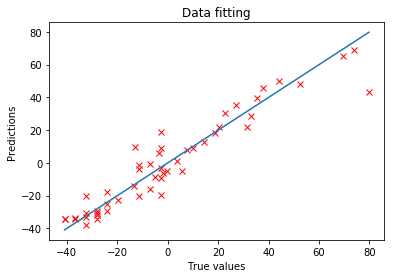

In [122]:
#%% Testing on dataset with second order polynomial degree without heldout validation 
l = 0.03
#Design matrix
Phi = np.column_stack((np.ones(X_sd.shape[0]), X_sd, X_sd**2)) 
#Parameter estimation
w_hat = reg_least_squares_fit (Phi, y_cent, l)
#Predicted response variable
y_hat = np.dot(Phi, w_hat)
#Sum of square errror
ssr =((y_hat - y_cent)**2).sum()

#Plotting for data to visualize data fitting
plt.plot(y_cent, y_hat,'rx')
plt.plot(y_temp, y_temp)
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('Data fitting')

print('Weights:' +str(w_hat))
print('SSR :%0.4f '%ssr)

R = coeff_det(y_cent, y_hat)
print ('R-Squared :%0.4f '%(R))


Furthermore, using second order polynomial basis function and without held out validation we can see that prediction error is 4220.19 i.e almost twice lower than without basis functions and an $R^2$ estimate of 0.9053. These statistical measures shows that we have improved our estimate compared with simple linear ridge regression.